# 1. Import the relevant libraries and functions

In [97]:
import os
import xml.etree.ElementTree as ET

# import matplotlib as mpl

# new_rc_params = {'text.usetex': False,
# "svg.fonttype": 'none'
# }
# mpl.rcParams.update(new_rc_params)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import ranksums

import matplotlib as mpl 
from matplotlib.ticker import AutoMinorLocator

# 2. Define the plotting parameters

In [2]:


new_rc_params = {'text.usetex': False, 
"svg.fonttype": 'none',
'font.size': 7,
"lines.linewidth" : 0.5,
"figure.figsize": (2,2),
"lines.markersize":4,
                 
"xtick.labelsize": 7,  
"ytick.labelsize": 7,   
"ytick.major.size": 5,
"xtick.major.size": 5,
"ytick.major.width": 1.1,
"xtick.major.width": 1.1,
"xtick.top" : False,
'xtick.minor.visible': True,   # visibility of minor ticks on x-axis
'ytick.minor.visible': True,
'xtick.minor.size': 3,   # visibility of minor ticks on x-axis
'ytick.minor.size': 3,
"ytick.minor.width": 1.1,
"xtick.minor.width": 1.1,
} 
mpl.rcParams.update(new_rc_params) 
image_format = "svg"

sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

sns.set_style({'ytick.right': True, 'xtick.top': True })
mpl.rcParams['svg.fonttype'] = 'none'  # Ensures text is saved as editable text

# 3. Functions to read the files

###### The XML files were generated using trackmate in imageJ. Parameters used were: nearest neighbour tracker, maximal linking distance 5 um, and minimal droplet size: 5um as well

In [3]:
# All this does is read the xml files which trackmate outputs, the exact way to read this depends of course on how you organize your data

# In this case the file organisation looks like this: 
#base_folder/
#│── rep1/
#│   ├── conditionA/
#│   │   ├── file1.xml
#│   │   ├── file2.xml
#│   ├── conditionB/
#│       ├── file3.xml
#│── rep2/
#    ├── conditionA/
#    │   ├── file4.xml
#    ├── conditionB/
#        ├── file5.xml



def read_all_xml_files(base_folder):
    xml_files = []
    for rep_folder in os.listdir(base_folder):
        rep_path = os.path.join(base_folder, rep_folder)
        if os.path.isdir(rep_path):
            for condition_folder in os.listdir(rep_path):
                condition_path = os.path.join(rep_path, condition_folder)
                if os.path.isdir(condition_path):
                    for file_name in os.listdir(condition_path):
                        if file_name.endswith('.xml'):
                            file_path = os.path.join(condition_path, file_name)
                            xml_files.append(file_path)
    return xml_files



#Read all the XML files and extract the trajectory of single droplets over time
## Recursively explore the structure

### The only goal of this function is literally to just understand how trackmate organized the data in the xml file (we should remove this)

def explore_element(element, level=0):
    indent = "  " * level
    print(f"{indent}{element.tag} {element.attrib}")
    for child in element:
        explore_element(child, level + 1)
        
## Parse the TrackMate XML file

# So this goes through the xml file and finds the "spots" and the "tracks": 

# Spots = individual detected droplets at different time points
# Tracks = linked droplets forming a trajectory over time, edges is what connects the same droplet over different timepoints 


def parse_trackmate(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    spots = {}
    tracks = []

    # Find all spots
    for spot in root.findall(".//Spot"):
        spot_id = spot.attrib['ID']
        x = float(spot.attrib['POSITION_X'])
        y = float(spot.attrib['POSITION_Y'])
        t = float(spot.attrib['POSITION_T'])
        spots[spot_id] = {"x": x, "y": y, "t": t}

    # Find all tracks
    for track in root.findall(".//Track"):
        track_id = track.attrib['TRACK_ID']
        edges = []
        for edge in track.findall(".//Edge"):
            source_id = edge.attrib['SPOT_SOURCE_ID']
            target_id = edge.attrib['SPOT_TARGET_ID']
            edges.append((source_id, target_id))
        tracks.append({"track_id": track_id, "edges": edges})

    return spots, tracks

## Combine tracks and spots into trajectories, this now combines the detections (=spots) and the droplets that are linked (=tracks)

# To better understand, this is what the ouput will look like: 
    #trajectories = [
    #{"track_id": "1", "trajectory": [
    #    ({"x": 5.0, "y": 6.0, "t": 0.0}, {"x": 6.0, "y": 7.0, "t": 1.0})
    #]}
    #]
def get_trajectories(spots, tracks):
    trajectories = []

    for track in tracks:
        trajectory = []
        for source_id, target_id in track['edges']:
            if source_id in spots and target_id in spots:
                # print(source_id, target_id)
                trajectory.append((spots[source_id], spots[target_id]))
        trajectories.append({"track_id": track["track_id"], "trajectory": trajectory})

    return trajectories

# Now all this function does is go through the files and group the trajectories
def group_trajectories (files):
    all_trajectories = []
    for xml_file in files:
        # Parse the TrackMate XML file
        spots, tracks = parse_trackmate(xml_file)

        # Build trajectories
        trajectories = get_trajectories(spots, tracks)
        all_trajectories.extend(trajectories)
    return all_trajectories

#### Functions to extract the top trajectories

In [4]:
# Function to count trajectories in a given set of files
def count_trajectories(files):
    total_trajectories = 0
    for xml_file in files:
        # Parse the TrackMate XML file
        spots, tracks = parse_trackmate(xml_file)

        # Build trajectories
        trajectories = get_trajectories(spots, tracks)
        print(len(trajectories))
        total_trajectories += len(trajectories)
    return total_trajectories



# Get the top n trajectories for each condition
def top_n_traj(trajectories,n):
    sd_values = []
    for idx, trajectory in enumerate(trajectories):
        # print(trajectory)
        sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
        # print(sorted_trajectory)
        # Extract x and y positions
        xs = np.array([point[0]['x'] for point in sorted_trajectory])
        ys = np.array([point[0]['y'] for point in sorted_trajectory])
        ts = np.array([point[0]['t'] for point in sorted_trajectory])

        # Compute SD for this trajectory
        if len(ts) > 1:
            sd, lag = compute_sd(xs, ys, ts)
            sd_values.append((trajectory, np.max(sd)))
        
    # Sort the trajectories based on MSD values in descending order
    sorted_trajectories = sorted(sd_values, key=lambda x: x[1], reverse=True)
    # Select the top n trajectories with the highest MSD
    top_trajectories = [None] * n
    for i in range(n):
        top_trajectories[i]=list(sorted_trajectories[i])[0]


    return top_trajectories


def mean_trajectories(trajectories):
    msd = []
    mlag = []
    for idx, trajectory in enumerate(trajectories):
        # print(trajectory)
        sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
        # print(sorted_trajectory)

        # Extract x and y positions
        xs = np.array([point[0]['x'] for point in sorted_trajectory])
        ys = np.array([point[0]['y'] for point in sorted_trajectory])
        ts = np.array([point[0]['t'] for point in sorted_trajectory])
        # print(ts,xs,ys)

        # Compute SD for this trajectory
        if len(ts) > 1:
            sd, lag = compute_sd(xs, ys, ts)
            msd.extend(sd)
            mlag.extend(lag)
        
    #check if msd and lag have the same length, else flag an error
    if len(msd) != len(mlag):
        raise ValueError("Length of MSD and time differences during iteration must be the same.")
    #average all msd that has the same time difference by masking
    delta = np.unique(mlag) #find unique time differences
    # print(delta)
    msd_mean = []    
    msd_std = []
    msd = np.array(msd)
    for d in delta:
        # print(d)
        mask = mlag == d
        # print(np.mean(msd[mask]))
        msd_mean.append(np.mean(msd[mask]))
        msd_std.append(np.std(msd[mask]))
    
    return msd_mean, msd_std, delta

# 4. Functions for plotting the trajectories now

#### realize that these functions take as input  a list of trajectories. So before loading the data into these functions you need to group the data beforehand. (I.e. one list per condition, and group replicated)

## This function makes a "Medusa plot of the trajectories"

In [5]:
# This function makes a "Medusa plot" 

def plot_medusa(trajectories, output_file):
    """
    Create and save a medusa plot from the trajectories.
    
    Parameters:
        trajectories: List of trajectory dictionaries. Each trajectory should
                      have a "trajectory" key containing a list of points with 'x' and 'y'.
        output_file: Path to the output SVG file.
    """
    plt.figure(figsize=(6, 6))
    # Find the min and max time in the whole trajectories, to set the limits of the plot
    all_times = [point[0]['t'] for trajectory in trajectories for point in trajectory['trajectory']]
    min_time = min(all_times)
    max_time = max(all_times)
    print(min_time, max_time)

    # for each droplet over time we put a dot at each timepoint (so we iterate over each trajectory)
    for trajectory in trajectories:
        sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
        xs = [point[0]['x'] for point in sorted_trajectory]
        ys = [point[0]['y'] for point in sorted_trajectory]
        # Shift the trajectory to start at the origin (0,0)
        xs = [x - xs[0] for x in xs]
        ys = [y - ys[0] for y in ys]
        
        # Normalize time for color mapping
        cmap = plt.get_cmap('viridis')
        norm = plt.Normalize(vmin=min_time, vmax=max_time)
        
        for i in range(len(xs) - 1):
            plt.plot(xs[i:i+2], ys[i:i+2], marker='o', linestyle='-', linewidth = 0.5, markersize=2, color=cmap(norm(sorted_trajectory[i][0]['t'])))
    
    plt.xlabel("X Position [µm]")
    plt.ylabel("Y Position [µm]")
    plt.xlim(-150, 150)
    plt.ylim(-150, 150)
    plt.MultipleLocator(25)
    plt.title("Medusa Plot of Trajectory Data")
    plt.savefig(output_file, format='svg', dpi = 1200)
    plt.grid("on")
    plt.show()
    # plt.close()

    # Create a separate figure for the color bar
    fig, ax = plt.subplots(figsize=(3, 1))
    fig.subplots_adjust(bottom=0.5)

    # Create a color bar with the same normalization and colormap
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    cb.set_label('Time (hours)')

    # Set ticks to show time in hours
    ticks = np.arange(norm.vmin, norm.vmax, 36000)  # 36000 seconds = 10 hours
    cb.set_ticks(ticks)
    cb.set_ticklabels([f"{tick / 3600:.0f}" for tick in ticks])
    # Save the color bar as a separate SVG file
    color_bar_output_file = output_file.replace('.png', '_colorbar.png')
    plt.savefig(color_bar_output_file, format='PNG')
    plt.show()
    plt.close()



In [6]:
def plot_medusa(trajectories, output_file):
    """
    Create and save a medusa plot from the trajectories.
    
    Parameters:
        trajectories: List of trajectory dictionaries. Each trajectory should
                      have a "trajectory" key containing a list of points with 'x' and 'y'.
        output_file: Path to the output SVG file.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Find the min and max time in the whole trajectories, to set the limits of the plot
    all_times = [point[0]['t'] for trajectory in trajectories for point in trajectory['trajectory']]
    min_time = min(all_times)
    max_time = max(all_times)
    print(min_time, max_time)

    # for each droplet over time we put a dot at each timepoint (so we iterate over each trajectory)
    for trajectory in trajectories:
        sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
        xs = [point[0]['x'] for point in sorted_trajectory]
        ys = [point[0]['y'] for point in sorted_trajectory]
        # Shift the trajectory to start at the origin (0,0)
        xs = [x - xs[0] for x in xs]
        ys = [y - ys[0] for y in ys]
        
        # Normalize time for color mapping
        cmap = plt.get_cmap('viridis')
        norm = plt.Normalize(vmin=min_time, vmax=max_time)
        
        for i in range(len(xs) - 1):
            ax.plot(xs[i:i+2], ys[i:i+2], marker='o', linestyle='-', linewidth=0.5, markersize=2, 
                    color=cmap(norm(sorted_trajectory[i][0]['t'])))
    
    ax.set_xlabel("X Position [µm]")
    ax.set_ylabel("Y Position [µm]")
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    #ax.set_title("Medusa Plot of Trajectory Data")
    ax.grid(True)
    
    # Set major and minor ticks
    from matplotlib.ticker import MultipleLocator
    ax.xaxis.set_major_locator(MultipleLocator(50))
    ax.xaxis.set_minor_locator(MultipleLocator(25))
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(25))
    
    plt.savefig(output_file, format='png',dpi=300)
    plt.show()
    
    # Create a separate figure for the color bar
    fig, ax = plt.subplots(figsize=(3, 1))
    fig.subplots_adjust(bottom=0.5)

    # Create a color bar with the same normalization and colormap
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    cb.set_label('Time (hours)')

    # Set ticks to show time in hours
    ticks = np.arange(norm.vmin, norm.vmax, 36000)  # 36000 seconds = 10 hours
    cb.set_ticks(ticks)
    cb.set_ticklabels([f"{tick / 3600:.0f}" for tick in ticks])
    
    # Save the color bar as a separate SVG file
    color_bar_output_file = output_file.replace('.png', '_colorbar.png')
    plt.savefig(color_bar_output_file, format='PNG')
    plt.show()
    plt.close()


## This plots the MSD over time

### Note that MSD looks at the average displacement at timepoin t*
### so at each timepoint t* the position of the droplet is compared to its origin/position at timepoint 0

In [7]:
#Plot MSD
def compute_sd(xs, ys, ts):
    """
    Compute the squared displacement for a single trajectory with irregular time points.
    
    Parameters:
        xs: Array of x positions.
        ys: Array of y positions.
        ts: Array of time points in seconds.
        
    Returns:
        sd: Array of squared displacement values.
        lag: Array of time differences
    """
    #check if len of xs, ys, ts are the same, else flag an error
    if len(xs) != len(ys) or len(xs) != len(ts):
        raise ValueError("Length of x,y coordinates, and time must be the same.")
    #convert ts to hours
    ts = np.round(ts / 3600, 2) #round to 2 decimal places
    # Iterate over all possible time points and calculate all possible time differences
    sd = []
    lag = []
    n_points = len(ts)
    for i in range(n_points):
        lag.append(ts[i] - ts[0])
        dx = xs[i] - xs[0]
        dy = ys[i] - ys[0]
        sd.append(dx**2 + dy**2)
    sd = np.array(sd)
    lag = np.array(lag)
    return sd,lag


In [8]:
def plot_msd(trajectories,output_file):
    """
    Plot the MSD for every single trajectory.
    
    Parameters:
        trajectories: List of trajectory dictionaries. Each trajectory should
                      have a "trajectory" key containing a list of points with 'x' and 'y'.
    """
    plt.figure(figsize=(8, 6))
    for idx, trajectory in enumerate(trajectories):
        # print(trajectory)
        sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
        # print(sorted_trajectory)

        # Extract x and y positions
        xs = np.array([point[0]['x'] for point in sorted_trajectory])
        ys = np.array([point[0]['y'] for point in sorted_trajectory])
        ts = np.array([point[0]['t'] for point in sorted_trajectory])
        # print(ts,xs,ys)

        # Compute SD for this trajectory
        if len(ts) > 1:
            sd, lag = compute_sd(xs, ys, ts)
            # Plot SD for this trajectory
            plt.plot(lag, sd, alpha = 0.5)
    plt.xlabel("Time [hours]")
    plt.ylabel("Squared Displacement (SD)")
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.xlim(0, 60)
    # plt.ylim(0.0001, 10000)
    plt.title("MSD for Each Trajectory (Linear Scale)")
    plt.savefig(output_file, format='png')
    plt.show()
    plt.close()



# 5. Now we can start the actual plotting

In [ ]:
# Pool all replicates and plot the two phenotypes
base_folder = '/Users/Downloads/****/'

xml_files = read_all_xml_files(base_folder)
# Separate the xml files into wt and mut groups
wt_files = [file for file in xml_files if '/wt/' in file]
mut_files = [file for file in xml_files if '/mut/' in file]

In [13]:
# Separate the xml files into wt and mut groups
wt_files = [file for file in xml_files if '/wt/' in file]
mut_files = [file for file in xml_files if '/mut/' in file]

# Function to process and plot the data for a given set of files
# So here label refers to the conditio  (wt or mut)
def process_and_plot(files, label):
    all_trajectories = []
    for xml_file in files:
        # Parse the TrackMate XML file
        spots, tracks = parse_trackmate(xml_file)

        # Build trajectories
        trajectories = get_trajectories(spots, tracks)
        all_trajectories.extend(trajectories)

    
    # Plot Medusa
    output_file = f"{base_folder}/{label}_medusa.png"
    plot_medusa(all_trajectories, output_file)

    # Plot SD per trajectory
    print(base_folder)
    output_file = f"{base_folder}/{label}_sd.png"
    plot_msd(all_trajectories,output_file)


    # Plot MSD for all trajectories
    msd = []
    mlag = []
    for idx, trajectory in enumerate(all_trajectories):
        # print(trajectory)
        sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
        # print(sorted_trajectory)

        # Extract x and y positions
        xs = np.array([point[0]['x'] for point in sorted_trajectory])
        ys = np.array([point[0]['y'] for point in sorted_trajectory])
        ts = np.array([point[0]['t'] for point in sorted_trajectory])
        # print(ts,xs,ys)

        # Compute SD for this trajectory
        if len(ts) > 1:
            sd, lag = compute_sd(xs, ys, ts)
            msd.extend(sd)
            mlag.extend(lag)
        
    #check if msd and lag have the same length, else flag an error
    if len(msd) != len(mlag):
        raise ValueError("Length of MSD and time differences during iteration must be the same.")
    #average all msd that has the same time difference by masking
    delta = np.unique(mlag) #find unique time differences
    # print(delta)
    msd_mean = []    
    msd_std = []
    msd = np.array(msd)
    for d in delta:
        # print(d)
        mask = mlag == d
        # print(np.mean(msd[mask]))
        msd_mean.append(np.mean(msd[mask]))
        msd_std.append(np.std(msd[mask]))
    
    # Plot MSD for all trajectories with connecting line and shaded error region
    plt.figure(figsize=(8, 6))
    plt.plot(delta, msd_mean, label='Mean MSD')
    plt.fill_between(delta, 
                     np.array(msd_mean) - np.array(msd_std), 
                     np.array(msd_mean) + np.array(msd_std), 
                     color='b', alpha=0.2, label='Standard Deviation')
    plt.xlabel('Time [hours]')
    plt.ylabel('Mean Squared Displacement (MSD)')
    plt.ylim(-2000, 6000)
    plt.title(f'MSD for {label}')
    plt.legend()
    plt.savefig(f"{base_folder}/{label}_MSD.png", format='png')
    plt.show()
    plt.close()


Non-filtered processing

0.0 200469.72276720003


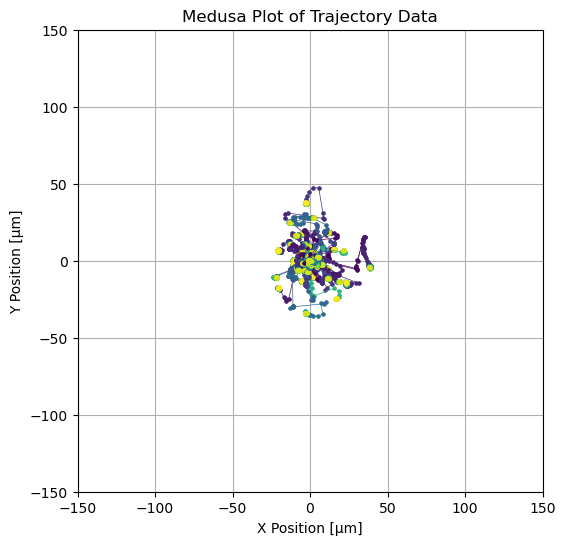

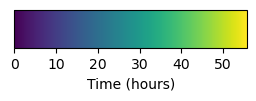

/Users/wverstra/Downloads/forWill 2/


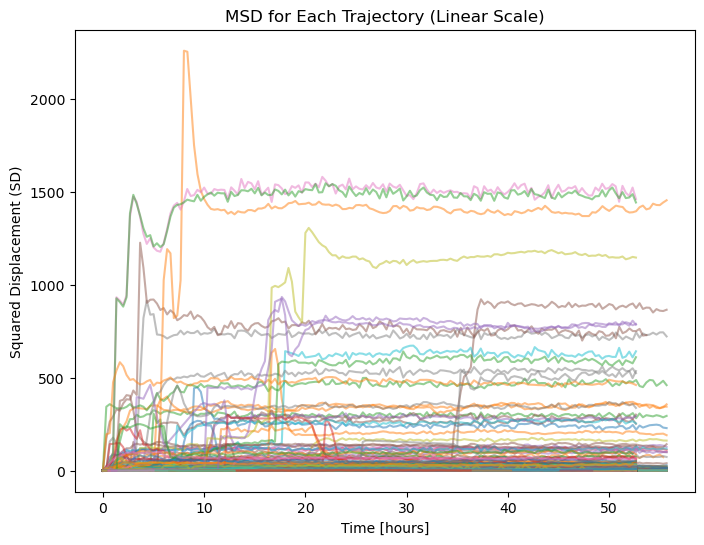

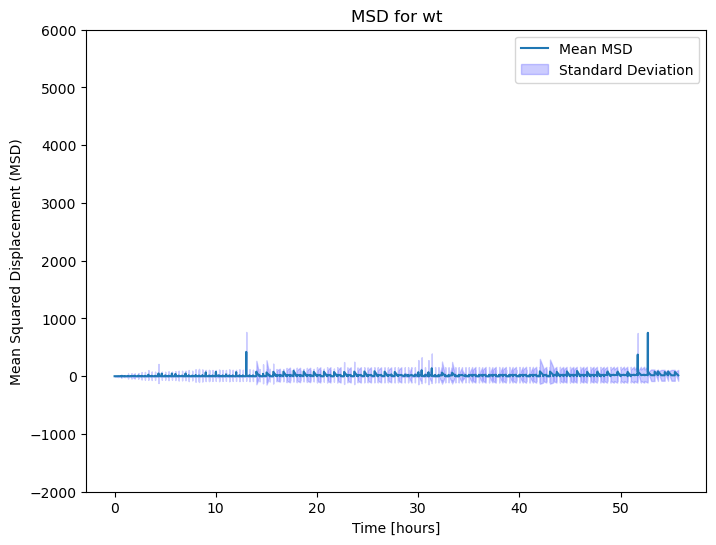

0.0 200469.72276720003


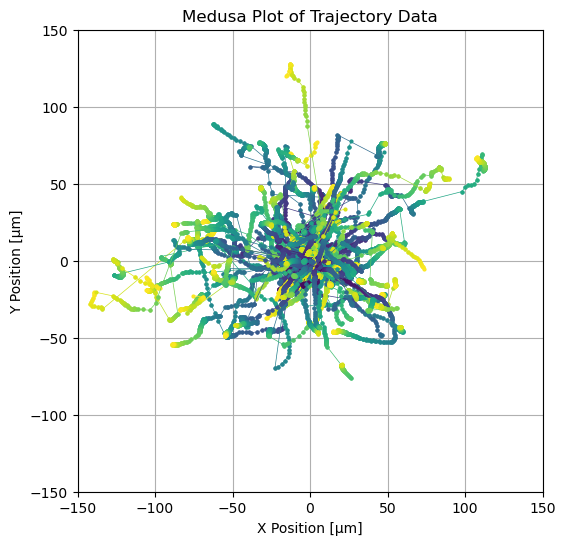

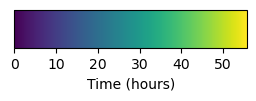

/Users/wverstra/Downloads/forWill 2/


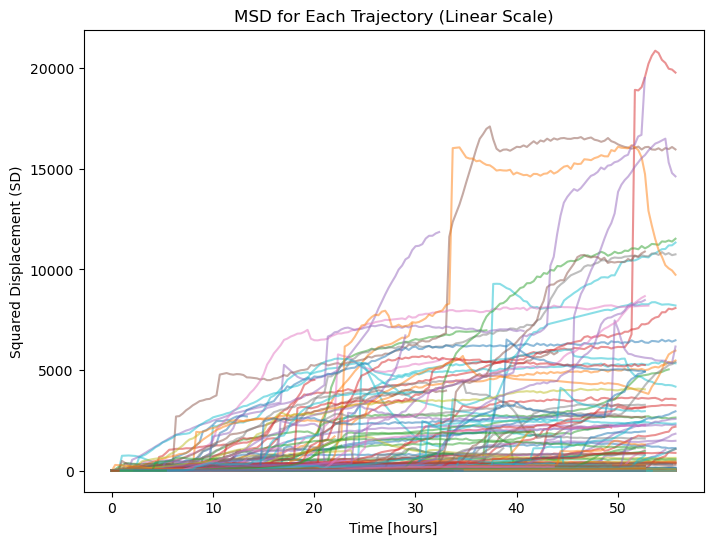

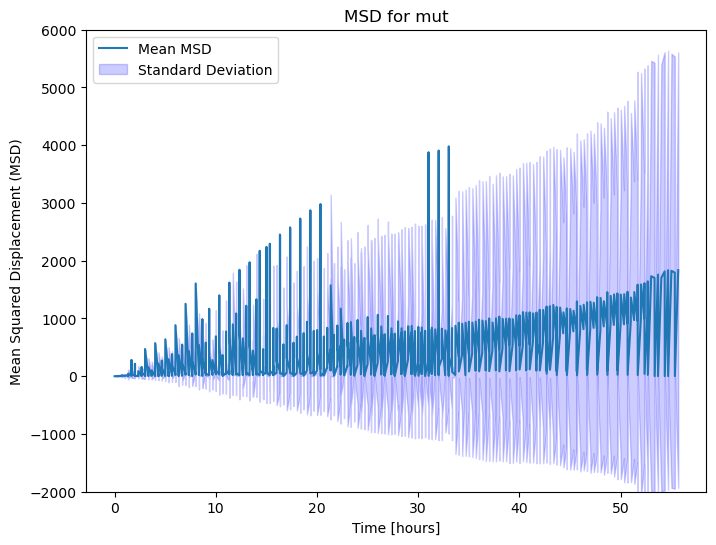

In [14]:
# Process and plot for wt
process_and_plot(wt_files, 'wt')

# Process and plot for mut
process_and_plot(mut_files, 'mut')

# Here we plot things individually for easier data visualization

In [10]:
# Separate the xml files into wt and mut groups
wt_files = [file for file in xml_files if '/wt/' in file]
mut_files = [file for file in xml_files if '/mut/' in file]

In [11]:
# Count trajectories for WT and mut
wt_trajectory_count = count_trajectories(wt_files)
mut_trajectory_count = count_trajectories(mut_files)

print(f"Number of trajectories in WT: {wt_trajectory_count}")
print(f"Number of trajectories in mut: {mut_trajectory_count}")

203
148
187
156
298
343
284
87
126
133
124
121
124
60
Number of trajectories in WT: 1619
Number of trajectories in mut: 775


In [13]:
WT_trajectories = []
for xml_file in wt_files:
    # Load the XML file
    file_path = xml_file

    # Parse the TrackMate XML file
    spots, tracks = parse_trackmate(file_path)

    # Build trajectories
    trajectories = get_trajectories(spots, tracks)
    WT_trajectories.extend(trajectories)
    
Mut_trajectories = []
for xml_file in mut_files:
    # Load the XML file
    file_path = xml_file

    # Parse the TrackMate XML file
    spots, tracks = parse_trackmate(file_path)

    # Build trajectories
    trajectories = get_trajectories(spots, tracks)
    Mut_trajectories.extend(trajectories)

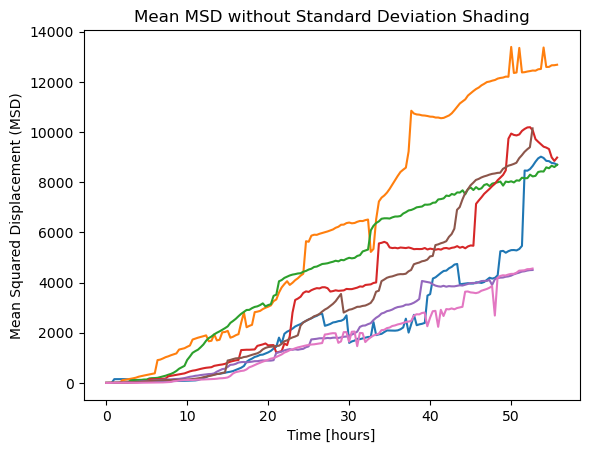

here every curve shows for one field of view the mean displacement of the top 5 trajectories


In [ ]:
for xml_file in mut_files:
    all_trajectories = []
    # Load the XML file
    file_path = xml_file

    # Parse the TrackMate XML file
    spots, tracks = parse_trackmate(file_path)

    # Build trajectories
    trajectories = get_trajectories(spots, tracks)
    all_trajectories.extend(trajectories)
    
    top_5_trajectories = top_n_traj(trajectories,5)
    
    msd_mean, msd_std, delta = mean_trajectories(top_5_trajectories)
    
    # Plot the mean values
    plt.plot(delta, msd_mean, label='Mean MSD')

    # Plot the shading for standard deviation
    # plt.fill_between(delta, 
    #                 [mean - std for mean, std in zip(msd_mean, msd_std)], 
    #                 [mean + std for mean, std in zip(msd_mean, msd_std)], 
    #                 alpha=0.2, label='Standard Deviation')

    plt.xlabel('Time [hours]')
    plt.ylabel('Mean Squared Displacement (MSD)')
    plt.title('Mean MSD without Standard Deviation Shading')
    # plt.ylim(0, 14000)
    # plt.legend()
    
plt.show()
print("here every curve shows for one field of view the mean squared displacement of the top 5 trajectories")


In [105]:
# Now lets try to compute the MSD  at the final position for every condition: 
top_trajectories = top_n_traj(WT_trajectories,100)
final_displacement_WT = []

for idx, trajectory in enumerate(top_trajectories):
    # print(trajectory)
    sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
    
# Extract x and y positions
    xs = np.array([point[0]['x'] for point in sorted_trajectory])
    ys = np.array([point[0]['y'] for point in sorted_trajectory])
    ts = np.array([point[0]['t'] for point in sorted_trajectory])
    # print(ts,xs,ys)
    
    # Compute SD for this trajectory
    if len(ts) > 1:
        MSD, lag = compute_sd(xs, ys, ts)
    final_displacement_WT.append(MSD[-1])


top_trajectories = top_n_traj(Mut_trajectories,100)
final_displacement_Mut = []

for idx, trajectory in enumerate(top_trajectories):
    # print(trajectory)
    sorted_trajectory = sorted(trajectory['trajectory'], key=lambda point: point[0]['t'])
    
# Extract x and y positions
    xs = np.array([point[0]['x'] for point in sorted_trajectory])
    ys = np.array([point[0]['y'] for point in sorted_trajectory])
    ts = np.array([point[0]['t'] for point in sorted_trajectory])
    # print(ts,xs,ys)
    
    # Compute SD for this trajectory
    if len(ts) > 1:
        MSD, lag = compute_sd(xs, ys, ts)
    final_displacement_Mut.append(MSD[-1])


print("Based on the top 100 most mobile droplets in both conditions, the average MSD of a droplet in the WT is " + str(np.mean (final_displacement_WT)) 
      + " The average movement of a droplet in the Mutant1 " + str(np.mean(final_displacement_Mut)) )

Based on the top 100 most mobile droplets in both conditions, the average MSD of a droplet in the WT is 191.19151717930072 The average movement of a droplet in the Mutant1 3998.3146838991943


/var/folders/9z/200xn02d4qg4f0433g7nw2580000gp/T/ipykernel_13661/1303547277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['WT1', 'Mut1'])


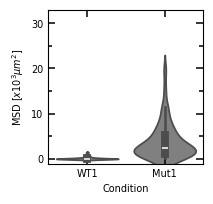

In [106]:
df1 = pd.DataFrame(final_displacement_WT)
df1["Condition"] = "WT"
df2 = pd.DataFrame(final_displacement_Mut)
df2["Condition"] = "Mut"
data = pd.concat([df1,df2], ignore_index=True)
data[0] = data[0]*0.001 

plt.locator_params(axis='y', nbins=4)

g = sns.violinplot(data, x = "Condition", y = 0, density_norm = "width", color='gray')#, palette = [cM,cML,cMS,c4], alpha = 1)#, “count”, “width”})
g.set_xticklabels(['WT1', 'Mut1'])
g.yaxis.set_minor_locator(plt.MultipleLocator(5))
g.xaxis.set_minor_locator(plt.MultipleLocator(2500))

plt.ylabel(r'MSD [$x10^3 μm^2$]', fontsize = 7)
plt.ylim([-1, 33])
plt.savefig("Vplot_MSD.svg", format = "svg", dpi = 1200)




In [100]:
from scipy.stats import median_test

sample1 = df1[0].values.flatten()

sample2 = df2[0].values.flatten()



print(np.median(sample1), np.median(sample2))
print(ranksums(sample1, sample2))


stat, p, med, tbl = median_test(sample1, sample2)
print("according to the median test this is the p-value between group 1 and group 2 :"+ str(p))



55.44239272852748 2417.828622508955
RanksumsResult(statistic=-11.752700547076563, pvalue=6.839744077356578e-32)
according to the median test this is the p-value between group 1 and group 2 :2.7623240713337928e-33


In [77]:
# Here we're going to make an SVG plot of the medusa, but take the top X trajectories for both Mut and WT
mpl.rcParams['svg.fonttype'] = 'none'
top_trajectories_WT = top_n_traj(WT_trajectories , 50)
top_trajectories_Mut = top_n_traj(Mut_trajectories , 50)

0.0 200469.72276720003


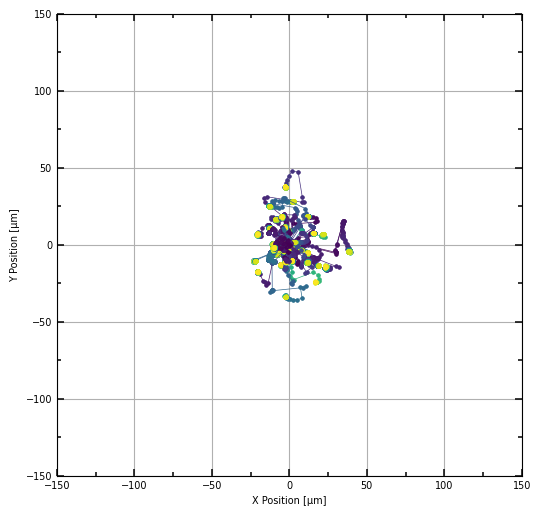

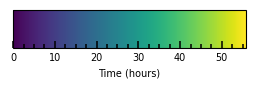

In [81]:
plot_medusa(top_trajectories_WT, "test.png")

0.0 200469.72276720003


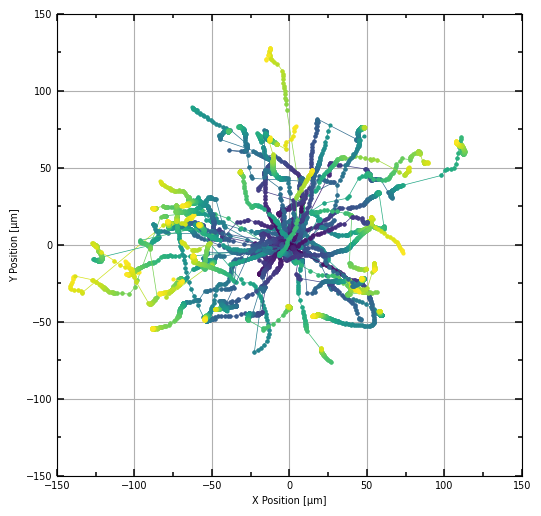

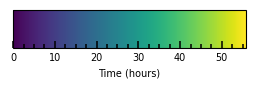

In [82]:
plot_medusa(top_trajectories_Mut, "Mut.png")

Troubleshooting code